In [67]:
import h5py
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns


def image_extraction(filename:str) -> tuple[np.array, pd.DataFrame]:
    """Extract images aswell as the foldless dataset. The indeces will match between ds and image array, but not ID."""
    dataset = h5py.File(filename, 'r')
    ds = pd.DataFrame()
    for i, fold in enumerate(dataset.keys()):
        df=pd.DataFrame({'ID':np.array(dataset[fold]['patient_idx']),'target':np.array(dataset[fold]['y']),'diagnosis':np.array(dataset[fold]['diagnosis']),'fold':i})
        ds=pd.concat([ds,df],ignore_index=True,axis=0,keys=['','fold {}'.format(fold)]) # ignore index to match index with image indeces
    #ds.set_index("ID", inplace = True)
    images=np.array(dataset['fold_0']['x'])
    images = np.append(images,np.array(dataset['fold_1']['x']),axis=0)
    images=np.append(images,np.array(dataset['fold_2']['x']),axis=0)
    images=np.append(images,np.array(dataset['fold_3']['x']),axis=0)
    images=images.reshape(len(images),800,800)
    dataset.close()
    return images, ds


def test_result_extraction(filename):
    """Make dataframe of prediction."""
    f = h5py.File(filename, 'r')
    pred = np.array(f['predicted'][:])
    patient = np.array(f['patient_idx'][:])
    y = np.array(f['y'][:]).argmax(axis=1)
    f.close()

    df = pd.DataFrame({'pred':pred.argmax(axis=1),'label': y},index=patient)

    df['prob']=np.round(np.round(pred.max(axis=1),2),2)
    df['pred']=np.round(df['pred'],0)
    df['label']=df['label']
    return df
       
def check_wrong(df, show_images=True, original_dataset=None, images=None):
    """
    df: the .h5 file of the test result
    """
    diagnoses=['normal','1, artrose/ sklerose','2, artrose', '2, MCD',
               '3, artrose', '3, MCD', '3, OCD', '3, UAP']
    wrong=df.iloc[np.where(df['pred'].values!=df['label'])[0]].index
    plt.figure()
    confusion_matrix=sklearn.metrics.multilabel_confusion_matrix(df['label'],df['pred'])
    plt.figure()
    sns.heatmap(confusion_matrix[0],annot=True, fmt="d", linewidths=.5)
    plt.title('Confusion matrix with level 1 as positive')
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()

    plt.figure()
    sns.heatmap(confusion_matrix[1],annot=True, fmt="d", linewidths=.5)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title('Confusion matrix with level 2 as positive')
    plt.show()

    plt.figure()
    sns.heatmap(confusion_matrix[2],annot=True, fmt="d", linewidths=.5)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title('Confusion matrix with level 3 as positive')
    plt.show()

    df['result']= 'Correct'
    df.loc[wrong,('result')] = 'Wrong'

    df_wrong = df[df.result=='Wrong']

    plt.figure()
    plt.title('Prøver feilklassifisert som klasse 0 (nivå 1)')
    sns.histplot(df_wrong[df_wrong.pred==0], x='prob', bins=100, hue='label')

    plt.figure()
    plt.title('Prøver feilklassifisert som klasse 1 (nivå 2)')
    sns.histplot(df_wrong[df_wrong.pred==1], x='prob', bins=100, hue='label')

    plt.figure()
    plt.title('Prøver feilklassifisert som klasse 2 (nivå 3)')
    sns.histplot(df_wrong[df_wrong.pred==2], x='prob', bins=100, hue='label')
    
    plt.figure()
    plt.title('Rett predikerte prøver')
    sns.histplot(df[df['result']=='Correct'], x='prob', bins=100)

    plt.figure()
    #plt.xticks(np.unique(original_dataset.diagnosis),diagnoses,rotation=45)
    sns.countplot(x='pred',data=df.loc[wrong])
    plt.title('Fordeling av feilpredikerte i hvert nivå. \n (hvor mange ble feilpredikert som 0, 1 og 2)')
    plt.show()

    plt.figure()
    sns.countplot(x='label',data=df.loc[wrong])
    plt.title('Fordeling av feilpredikerte i hvert nivå. \n (hvor mange ble fra klasse 0, 1 og 2 ble predikert som noe annet)')
    plt.show()

    result_list=[]
    for i in wrong:
        if original_dataset is not None:
            result_list.append('ID: {}, prob: {:.2f}, True: {}'.format(original_dataset[original_dataset.ID==i].index[0],
                                                                    df.prob[i],
                                                                    original_dataset.diagnosis[original_dataset.ID==i].values[0]))
        if show_images==True:
            plt.figure()
            plt.imshow(images[original_dataset[original_dataset.ID==i].index[0]],'gray')
            plt.axis('off')
            plt.title('ID: {}, True: {}, Predicted: {:.2f}'.format(original_dataset[original_dataset.ID==i].index[0],
                                                                    diagnoses[int(original_dataset.diagnosis[original_dataset.ID==i].values[0])],
                                                                    df.prob[i]))
            plt.show()

    return result_list

In [65]:
#print(df.head())
wrong=df.iloc[np.where(df['pred'].values!=df['label'])[0]].index
df['result']= 'Correct'
df.loc[wrong,('result')] = 'Wrong'
df_wrong = df[df.result=='Wrong']


In [34]:
images, ds = image_extraction('//nmbu.no/Research/Project/CubiAI/preprocess/datasets/800_level_3.h5')
df = test_result_extraction('prediction11835987.h5')


<Figure size 640x480 with 0 Axes>

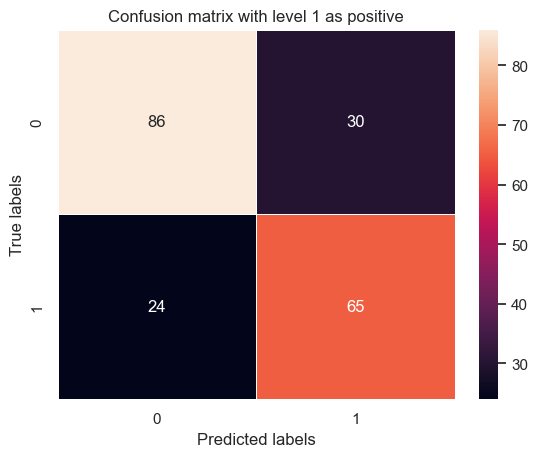

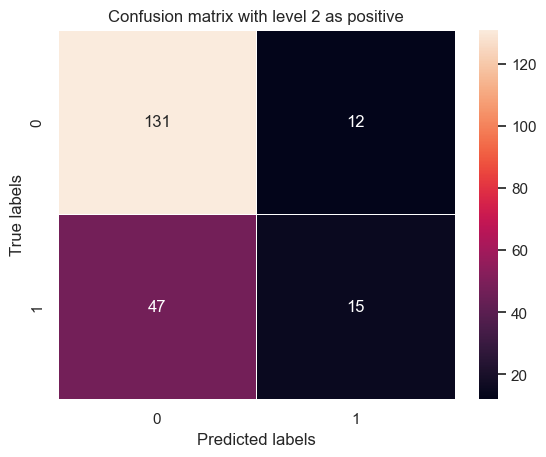

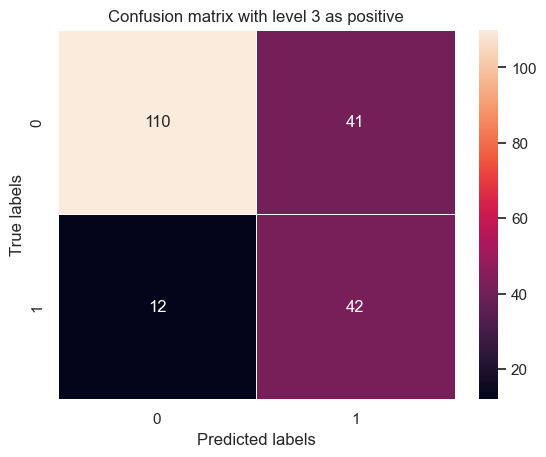

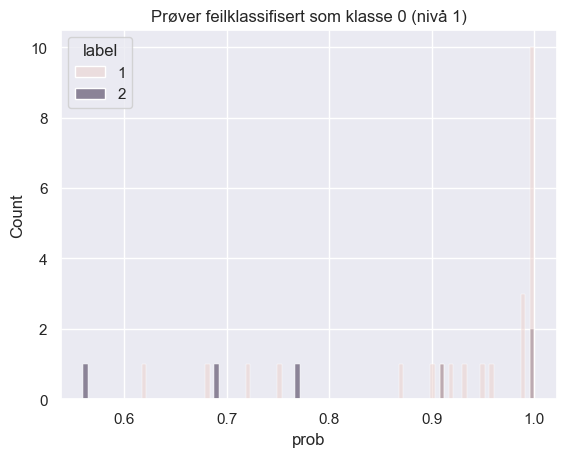

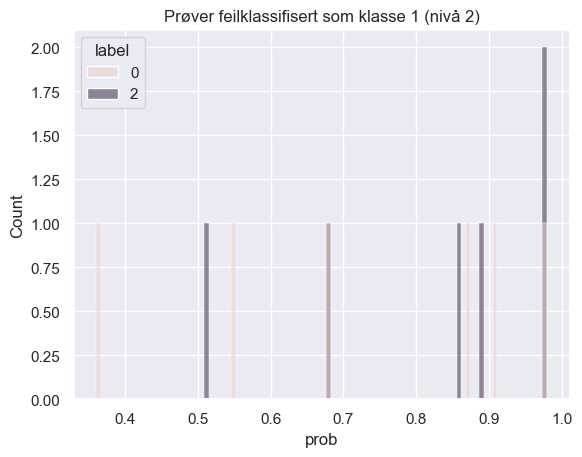

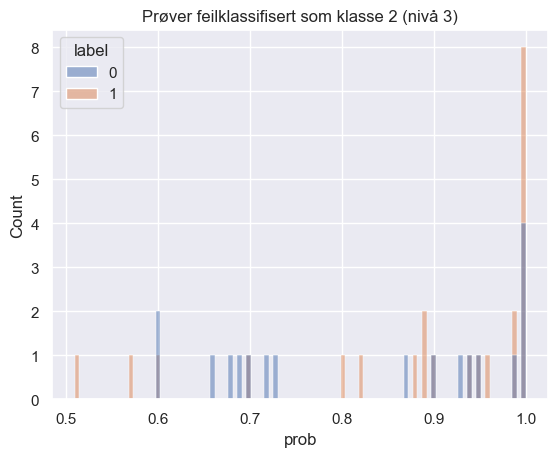

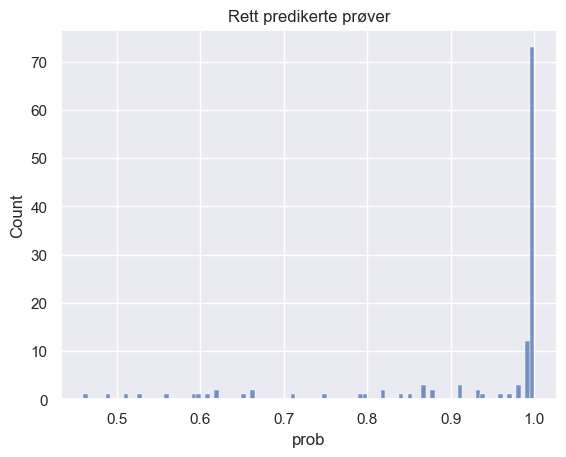

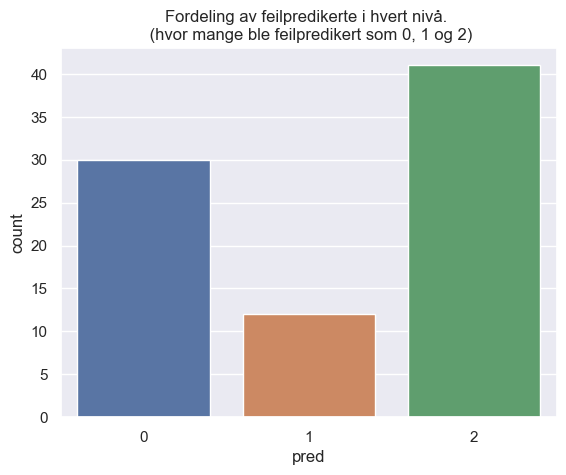

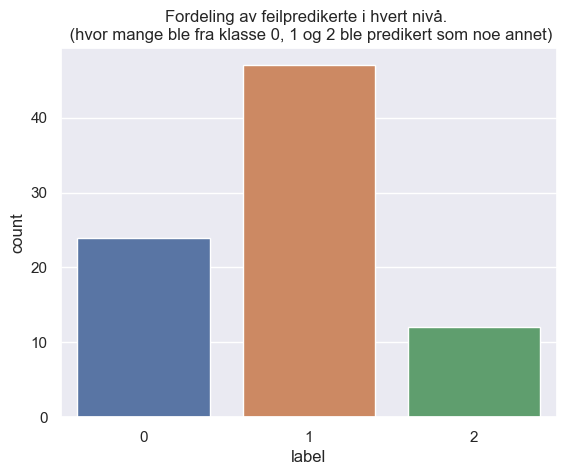

In [68]:
l=check_wrong(df,show_images=False, original_dataset=ds,images=images)